In [21]:
########################################
#             PATH SETUP
########################################

import sys
import glob
import os
sys.path.insert(0, os.path.abspath("."))

########################################
#             LIBRERIES SETUP
########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from pathlib import Path
from collections.abc import Iterable
from typing import Dict
import seaborn as sns
import math, re
########################################
#             SIMULATION LIBRARIES
########################################
from lemer.rngs import MultiStreamRNG
from lemer.rvms import *
from typing import List, Optional, Tuple
from simulator.simulation import Simulation

In [22]:
#Utils
_TCRIT_95 = {
    1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571, 6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262,
    10: 2.228, 11: 2.201, 12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131, 16: 2.120, 17: 2.110,
    18: 2.101, 19: 2.093, 20: 2.086, 21: 2.080, 22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060,
    26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042
}
def _tcrit(df: int) -> float:
    return _TCRIT_95.get(df, 1.96) if df > 0 else float("nan")

# --- aggregatore generico mean ± CI95% per metrica y raggruppata per x ---
def agg_ci(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    # NOTE: usa _tcrit(...) già definita UNA VOLTA nel tuo blocco utils
    g = df.groupby(x)[y].agg(["mean", "std", "count"]).reset_index()
    n = g["count"].to_numpy(dtype=float)
    t = np.where(n > 30, 1.96, np.array([_tcrit(int(max(1, k-1))) for k in n]))
    sem = g["std"].fillna(0.0).to_numpy() / np.sqrt(np.maximum(n, 1.0))
    ci = t * sem
    g["ci_lo"] = g["mean"] - ci
    g["ci_hi"] = g["mean"] + ci
    g["n"] = n
    return g.sort_values(x).reset_index(drop=True)



def mean_ci(series: pd.Series) -> Tuple[float, float, float, int]:
    x = pd.to_numeric(series, errors="coerce").dropna().values
    n = len(x)
    if n == 0: return np.nan, np.nan, np.nan, 0
    m = float(np.mean(x))
    if n == 1: return m, np.nan, np.nan, 1
    s = float(np.std(x, ddof=1))
    half = _tcrit(n-1) * s / math.sqrt(n)
    return m, m-half, m+half, n



def _node_order(scopes: list[str]) -> list[str]:
    """Ordina alfabeticamente i NODE_* (A,B,C,...) per avere pannelli stabili."""
    nodes = [s for s in scopes if isinstance(s, str) and s.startswith("NODE_")]
    return sorted(nodes, key=lambda s: s.replace("NODE_", ""))


def _node_label(scope: str) -> str:
    """Etichetta leggibile per un NODE_*."""
    name = scope.replace("NODE_", "")
    mapping = {"A":"Server A", "B":"Server B", "C":"Server C", "P":"Server P"}
    return mapping.get(name, f"Server {name}")


plt.rcParams.update({
    "figure.figsize": (7.4, 5.0),
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.35,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlelocation": "left",
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "legend.frameon": False,
    "lines.linewidth": 2.0,
    "lines.markersize": 5.5,
})
PALETTE = {
    "THEORY": "#1f77b4",   # blu per teoria
    "SIM":    "#ff7f0e",   # arancio per simulazione
    "A":      "#2ca02c",   # verde
    "B":      "#d62728",   # rosso
    "C":      "#000000",   # rosso
    "P":      "#9467bd",   # viola
}

MARKER_POOL = ["o", "s", "^", "D", "v", "P", "X", "*"]  # aggiungi se vuoi
def marker_style_for(index: int, color: str):
    m = MARKER_POOL[index % len(MARKER_POOL)]
    # ogni “giro” della lista alterna pieno/vuoto per aumentare la varietà
    hollow = (index // len(MARKER_POOL)) % 2 == 1
    return dict(
        marker=m, markersize=6.5,
        markerfacecolor=("white" if hollow else color),
        markeredgecolor=color, markeredgewidth=1.8,
    )









In [23]:

# ================== DISCOVERY / LOAD ==================
BASE_DIR = ".output_simulation"

def find_csv_for_config(config_path: str, base_dir=BASE_DIR, target="results") -> List[str]:
    cfg_name = Path(config_path).stem
    print(cfg_name)
    pattern  = os.path.join(base_dir, f"{target}_{cfg_name}*.csv")
    return sorted(glob.glob(pattern))

# regex seed più permissivo: _seed42, -seed=42, _seed-42, ecc.
_SEED_RE = re.compile(r"[ _-]seed[=_-]?(\d+)", re.IGNORECASE)

def _coerce_numeric(df: pd.DataFrame, exclude=("scope",)):
    """Converte in numerico tutte le colonne tranne quelle escluse; '-' -> NaN."""
    out = df.replace({"-": np.nan}).copy()
    for c in out.columns:
        if c not in exclude:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out



def _parse_lambda_from_filename(fname: str) -> Optional[float]:
    base = Path(fname).stem.lower()
    m = re.search(r"(?:lam|lambda|gamma|load)[=_]?([0-9]+(?:\.[0-9]+)?)", base)
    if m: return float(m.group(1))
    # fallback prudente
    for tok in re.findall(r"([0-9]+\.[0-9]+)", base):
        val = float(tok)
        if 0.1 <= val <= 5.0:
            return val
    return None

def load_runs(csv_files: List[str]) -> pd.DataFrame:
    dfs = []
    for i, f in enumerate(csv_files):
        df = pd.read_csv(f)
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        if "arrival_rate" not in df.columns:
            df["arrival_rate"] = _parse_lambda_from_filename(f)
        dfs.append(df)
    if not dfs:
        raise FileNotFoundError("Nessun CSV.")
    df = pd.concat(dfs, ignore_index=True)

    if "mean_response_time" not in df.columns:
        for alt in ("response_time_mean", "rt_mean"):
            if alt in df.columns:
                df = df.rename(columns={alt: "mean_response_time"})
                break
    return df


# ================== SCELTA X ==================

def choose_overall_x(df_overall: pd.DataFrame) -> Tuple[str, str]:
    """arrival_rate -> throughput -> replica"""
    if "arrival_rate" in df_overall.columns and df_overall["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "throughput" in df_overall.columns and df_overall["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

def choose_node_x(df_nodes: pd.DataFrame) -> Tuple[str, str]:
    if "arrival_rate" in df_nodes.columns and df_nodes["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "utilization" in df_nodes.columns and df_nodes["utilization"].nunique() >= 2:
        return "utilization", "Utilization ρ"
    if "throughput" in df_nodes.columns and df_nodes["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"



In [24]:

import pandas as pd
import os, glob
from pathlib import Path
import pandas as pd

import os, glob, re
from pathlib import Path
import pandas as pd

# Trova il CSV analitico a partire dal path della config (come fai per i results)
def find_analytic_csv_for_config(config_path: str, base_dir=BASE_DIR) -> str:
    cfg_name = Path(config_path).stem
    candidates = []
    patterns = [
        os.path.join(base_dir, f"analytic_sweep_{cfg_name}*.csv"),
        os.path.join(base_dir, f"{cfg_name}_analytic*.csv"),
        os.path.join(base_dir, "analytic_sweep_lambda.csv"),
        os.path.join(Path(base_dir).parent, "analytic_sweep_lambda.csv"),
    ]
    for pat in patterns:
        candidates += glob.glob(pat)

    if not candidates:
        raise FileNotFoundError(
            f"Nessun CSV analitico trovato per '{cfg_name}'. "
            f"Cercati pattern: {patterns}"
        )

    candidates.sort(key=lambda p: (len(Path(p).name), p), reverse=True)
    return candidates[0]

# Carica l’analitico nel formato atteso dal plot (colonne: arrival_rate, mean_response_time, X_max opzionale)
def load_analytic_models_for_config(config_path: str, base_dir=BASE_DIR) -> pd.DataFrame:
    path = find_analytic_csv_for_config(config_path, base_dir=base_dir)
    df = pd.read_csv(path)

    # uniforma la colonna lambda → arrival_rate
    if "arrival_rate" not in df.columns and "lambda" in df.columns:
        df = df.rename(columns={"lambda": "arrival_rate"})

    if "arrival_rate" not in df.columns:
        raise ValueError("Il CSV analitico deve contenere almeno 'arrival_rate' o 'lambda'.")

    # ordina per sicurezza
    return df.sort_values("arrival_rate").reset_index(drop=True)


# uso


In [25]:
########## helper per grafici con intervallo confidenza (PULITO)
# ============================================================
# Overlay simulazione (con CI) + analitico letto dal CSV
# Funziona con nodi arbitrari (A,B,P/…).
# Richiede nei CSV di simulazione: arrival_rate, mean_population, std_population, scope/vscope.
# Richiede nel CSV analitico: almeno ['arrival_rate' o 'lambda', 'mean_population'].
# Per i nodi, usa util_A/util_B/... dal CSV analitico e calcola N_i = λ * util_i.
# ============================================================

import math
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- util base ----------

def _z_value(conf: float = 0.95) -> float:
    """Valore critico z della Normale standard per il livello di confidenza."""
    if abs(conf - 0.95) < 1e-12:
        return 1.959963984540054
    lookup = {0.90: 1.6448536269514722, 0.95: 1.959963984540054, 0.975: 2.241402727604947, 0.99: 2.5758293035489004}
    return lookup.get(conf, 1.959963984540054)

def _pick_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    """Trova la prima colonna disponibile tra i candidati (case-insensitive)."""
    lowmap = {c.lower().strip(): c for c in df.columns}
    for name in candidates:
        key = name.lower().strip()
        if key in lowmap:
            return lowmap[key]
    return None

def _standardize_cols_inplace(df: pd.DataFrame) -> None:
    """Rende lo schema uniforme (rinomina colonne ai nomi canonici)."""
    scope_col = _pick_col(df, ["vscope", "scope", "node", "station", "component"])
    rate_col  = _pick_col(df, ["arrival_rate", "lambda", "lam", "arr_rate"])
    mean_col  = _pick_col(df, ["mean_population", "mean_pop", "avg_population", "population_mean", "E[N]", "meanN"])
    std_col   = _pick_col(df, ["std_population", "std_pop", "population_std", "sd_population", "sigma_population"])
    util_col  = _pick_col(df, ["utilization", "rho", "usage"])  # opzionale

    if scope_col is None: raise ValueError(f"Colonna di scope non trovata. Presenti: {list(df.columns)}")
    if rate_col  is None: raise ValueError(f"Colonna 'arrival_rate' non trovata. Presenti: {list(df.columns)}")
    if mean_col  is None: raise ValueError(f"Colonna 'mean_population' non trovata. Presenti: {list(df.columns)}")
    if std_col   is None: raise ValueError(f"Colonna 'std_population' non trovata. Presenti: {list(df.columns)}")

    ren = {scope_col: "vscope", rate_col: "arrival_rate", mean_col: "mean_population", std_col: "std_population"}
    if util_col: ren[util_col] = "utilization"
    df.rename(columns=ren, inplace=True)

def _normalize_scope_values_inplace(df: pd.DataFrame) -> None:
    """Uniforma i valori di scope a OVERALL e NODE_<X>."""
    df["vscope"] = df["vscope"].astype(str).str.strip().str.upper()
    df["vscope"] = df["vscope"].replace({"SYSTEM": "OVERALL", "TOTAL": "OVERALL", "ALL": "OVERALL"})
    df["vscope"] = df["vscope"].str.replace("NODE-", "NODE_", regex=False)
    mask_letter = df["vscope"].str.fullmatch(r"[A-Z]")
    df.loc[mask_letter, "vscope"] = "NODE_" + df.loc[mask_letter, "vscope"]

def _load_one(x) -> pd.DataFrame:
    """Carica un DF o un CSV e applica normalizzazioni."""
    if isinstance(x, pd.DataFrame):
        df = x.copy()
    elif isinstance(x, (str, pathlib.Path)):
        df = pd.read_csv(x, na_values=["-", "-,-"])
    else:
        raise TypeError(f"Tipo non supportato: {type(x)}")
    _standardize_cols_inplace(df)
    _normalize_scope_values_inplace(df)
    # tipi numerici
    for c in ["arrival_rate", "mean_population", "std_population", "utilization"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _ensure_df(files_or_path) -> pd.DataFrame:
    """Accetta DF / path / lista/tupla di DF o path e concatena tutto."""
    if isinstance(files_or_path, (list, tuple)):
        parts = [_load_one(it) for it in files_or_path]
        df = pd.concat(parts, ignore_index=True, sort=False)
    else:
        df = _load_one(files_or_path)
    return df

def _detect_nodes(df: pd.DataFrame) -> list[str]:
    """Estrae i nomi dei nodi presenti (NODE_<X>)."""
    mask = df["vscope"].str.startswith("NODE_")
    return sorted([v.split("NODE_")[1] for v in df.loc[mask, "vscope"].unique().tolist()])

# ---------- CI dalla simulazione ----------

def ci_from_files(files_or_path,
                  scope: str,
                  n_rep: int,
                  conf: float = 0.95,
                  ci_design_effect: float = 12.0,
                  n_departures_col: str | None = "num_departures") -> pd.DataFrame:
    """
    Media e semi-ampiezza IC per uno scope (OVERALL o NODE_<X>).
    - Se per un λ ci sono >=2 righe (repliche): usa varianza *tra repliche* delle MEDIE.
    - Se c'è 1 sola riga: fallback con n_eff = num_departures / ci_design_effect (>=1)
      usando la std intra-run (std_population).
    Ritorna: [arrival_rate, mean, ci] (dove 'ci' è la semi-ampiezza).
    """
    df = _ensure_df(files_or_path)
    sub = df[df["vscope"] == scope].copy()
    if sub.empty:
        raise ValueError(f"Nessuna riga per scope '{scope}'. Scopes: {sorted(df['vscope'].unique())}")

    # tipizza numerici
    for c in ["arrival_rate", "mean_population", "std_population"]:
        if c in sub.columns:
            sub[c] = pd.to_numeric(sub[c], errors="coerce")
    if n_departures_col and n_departures_col in sub.columns:
        sub[n_departures_col] = pd.to_numeric(sub[n_departures_col], errors="coerce")

    z = _z_value(conf)
    out_rows = []
    for lam, g in sub.groupby("arrival_rate", sort=True):
        vals = pd.to_numeric(g["mean_population"], errors="coerce").dropna()
        R = len(vals)

        if R >= 2:
            # CI tra repliche (sulla mean_population)
            m = float(vals.mean())
            s = float(vals.std(ddof=1)) if R > 1 else 0.0
            half = z * s / math.sqrt(R)
        else:
            # Fallback su una sola riga
            m = float(vals.iloc[0]) if len(vals) else float("nan")
            std_intra = float(g["std_population"].iloc[0]) if pd.notna(g["std_population"].iloc[0]) else 0.0
            if n_departures_col and n_departures_col in g.columns and pd.notna(g[n_departures_col].iloc[0]):
                n_eff = max(1.0, float(g[n_departures_col].iloc[0]) / float(ci_design_effect))
            else:
                n_eff = 1.0
            half = z * std_intra / math.sqrt(n_eff)

        out_rows.append({"arrival_rate": float(lam), "mean": m, "ci": max(0.0, half)})

    return (pd.DataFrame(out_rows)
              .sort_values("arrival_rate")
              .reset_index(drop=True))

# ---------- plotting dinamico con overlay (SIM vs ANALYTIC CSV) ----------

def plot_finite_population_dynamic(
    files_or_path,
    analytic_df: pd.DataFrame,     # CSV analitico già caricato con tutte le colonne
    *,
    n_rep: int,
    conf: float = 0.95,
    ci_design_effect: float = 12.0,
    node_order: list[str] | None = None,
    cols: int = 2,
    figsize=(12, 9),
    savepath: str | None = None,
    show_xticks_all: bool = True,
):
    """
    Pannelli dinamici: SYSTEM + uno per ciascun nodo trovato nei dati.
    Mostra sia simulazione (con CI) che modello analitico (dal CSV).
    """
    # --- dati simulazione ---
    df = _ensure_df(files_or_path)
    detected = _detect_nodes(df)
    nodes = (
        [n for n in (node_order or []) if n in detected]
        + [n for n in detected if (not node_order or n not in node_order)]
    )

    # CI simulazione
    ci_sys = ci_from_files(df, "OVERALL", n_rep, conf, ci_design_effect=ci_design_effect)
    ci_nodes = {n: ci_from_files(df, f"NODE_{n}", n_rep, conf, ci_design_effect=ci_design_effect)
                for n in nodes}

    # --- modello analitico dal CSV (tutte le colonne tenute come sono) ---
    model = analytic_df.copy()
    if "lambda" in model.columns:
        model = model.rename(columns={"lambda": "arrival_rate"})
    # SYSTEM: usa direttamente 'mean_population' dal CSV
    model = model.sort_values("arrival_rate").reset_index(drop=True)

    # --- layout figure ---
    n_panels = 1 + len(nodes)
    rows = math.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle("Confidence interval for average population", y=0.98)

    # --- SYSTEM ---
    ax = axs[0]
    ax.errorbar(ci_sys["arrival_rate"], ci_sys["mean"], yerr=ci_sys["ci"],
                fmt="o-", label="simulation run")
    if "mean_population" in model.columns:
        ax.plot(model["arrival_rate"], model["mean_population"], label="analytical model")
    ax.set_title("SYSTEM average population")
    ax.set_xlabel("Lambda"); ax.set_ylabel("Avg population in SYSTEM")
    ax.legend()

    # --- NODI ---
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d = ci_nodes[n]
        ax.errorbar(d["arrival_rate"], d["mean"], yerr=d["ci"],
                    fmt="o-", label="simulation run")

        # popolazione per nodo dai campi util_X * λ
        col_name = f"util_{n}"
        if col_name in model.columns:
            pop_n = model["arrival_rate"] * model[col_name]  # N_i(λ) = λ * ρ_i(λ)
            ax.plot(model["arrival_rate"], pop_n, label="analytical model")

        ax.set_title(f"{n} average population")
        ax.set_xlabel("Lambda"); ax.set_ylabel(f"Avg population in {n}")
        ax.legend()

    # pannelli extra (se grid più grande del necessario)
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)

    if show_xticks_all:
        for ax in axs:
            ax.tick_params(axis="x", which="both", labelbottom=True)

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


In [26]:
# === Utilities mancanti per plot_system_rt ===
import numpy as np
import pandas as pd
import math
_SEED_RE = re.compile(r"[ _-]seed[=_-]?(\d+)", re.IGNORECASE)

def _coerce_numeric(df: pd.DataFrame, exclude=("scope",)):
    """Converte in numerico tutte le colonne tranne quelle escluse; '-' -> NaN."""
    out = df.replace({"-": np.nan}).copy()
    for c in out.columns:
        if c not in exclude:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _seed_from_name(path: str) -> int | None:
    m = _SEED_RE.search(os.path.basename(path))
    return int(m.group(1)) if m else None


from scipy.stats import t as student_t

def aggregate_sim_overall(df_overall: pd.DataFrame,
                          *,
                          x_candidates=("arrival_rate", "throughput", "x"),
                          mean_col="mean_response_time",
                          # se presenti: colonna id replica e colonna n_departures
                          rep_candidates=("rep", "seed", "run", "iteration", "trial", "rep_id", "batch"),
                          n_departures_candidates=("num_departures","departures","n_departures"),
                          conf=0.95,
                          fallback_design_effect=8.0):
    """
    Aggrega OVERALL per λ con media e IC 95%:
    - Se ci sono più righe per λ (o una colonna 'rep'), fa IC *tra repliche* (consigliato).
    - Se per λ c'è una sola riga (dataset già collassato), evita di usare n_departures in modo ingenuo.
      In fallback usa la var tra 'repliche' se presente, altrimenti allarga in modo controllato
      con un 'design effect' (>1) sulla std intra-run (esplicita e modificabile).

    Ritorna:
      agg: DataFrame con colonne [xcol, 'mean', 'ci_lo', 'ci_hi']
      xcol: nome della colonna X usata
      xlabel: etichetta per asse X
    """
    df = df_overall.copy()

    # 1) scegli la X (λ normalmente)
    xcol = None
    for c in x_candidates:
        if c in df.columns:
            xcol = c
            break
    if xcol is None:
        raise ValueError(f"Nessuna colonna X tra {x_candidates} in df_overall.columns={list(df.columns)}")

    # 2) trova colonna id-replica se esiste
    rep_col = None
    for c in rep_candidates:
        if c in df.columns:
            rep_col = c
            break

    # 3) trova colonna n_departures (solo per fallback, NON per IC by-rep)
    ndep_col = None
    for c in n_departures_candidates:
        if c in df.columns:
            ndep_col = c
            break

    records = []
    for lam, g in df.groupby(xcol, sort=True):
        vals = pd.to_numeric(g[mean_col], errors="coerce").dropna()
        R = len(vals) if rep_col or len(g) > 1 else 1

        if R > 1:
            # >>> IC *tra repliche* (consigliato) <<<
            m = float(vals.mean())
            s = float(vals.std(ddof=1)) if R > 1 else 0.0
            tcrit = float(student_t.ppf(0.5 + conf/2.0, max(R-1, 1)))
            half = tcrit * s / math.sqrt(R)
            lo, hi = m - half, m + half
        else:
            # >>> Fallback (dataset già collassato per λ) <<<
            # NON usiamo n_departures "puri" (correlazione seriale); invece esplicitiamo un design effect.
            m = float(vals.iloc[0]) if len(vals) else np.nan
            # std intra-run, se c'è
            std_run = None
            for c in ("std_response_time", "std_rt", "std"):
                if c in g.columns and pd.notna(g[c].iloc[0]):
                    std_run = float(g[c].iloc[0]); break

            if std_run is None:
                # non posso costruire un IC credibile -> barra nulla
                lo, hi = m, m
            else:
                # n_eff = n_departures / design_effect (default 8: prudente in presenza di correlazione)
                n_eff = None
                if ndep_col and pd.notna(g[ndep_col].iloc[0]):
                    n_eff = max(1.0, float(g[ndep_col].iloc[0]) / float(fallback_design_effect))
                else:
                    n_eff = 1.0  # ultra-conservativo
                z = _z_value(conf)
                half = z * std_run / math.sqrt(n_eff)
                lo, hi = m - half, m + half

        records.append({xcol: float(lam), "mean": m, "ci_lo": lo, "ci_hi": hi})

    agg = pd.DataFrame(records).sort_values(xcol)
    xlabel = "Arrival Rate (λ)" if xcol == "arrival_rate" else xcol
    return agg, xcol, xlabel

def _seed_from_name(path: str) -> int | None:
    m = _SEED_RE.search(os.path.basename(path))
    return int(m.group(1)) if m else None

def _coerce_numeric(df: pd.DataFrame, exclude=("scope",)):
    """Converte in numerico tutte le colonne tranne quelle escluse; '-' -> NaN."""
    out = df.replace({"-": np.nan}).copy()
    for c in out.columns:
        if c not in exclude:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def load_conv_as_list(files: List[str]) -> List[pd.DataFrame]:
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # numeric coercion, ma NON toccare scope/metric
        df = _coerce_numeric(df, exclude=("scope", "metric"))
        df["seed"] = _seed_from_name(f)
        df["source"] = os.path.basename(f)
        dfs.append(df)
    return dfs  # <- LISTA di DataFrame (uno per file)



In [ ]:
# --- helper: prendi il primo campo disponibile tra vari alias ---
def _find_first(row, names):
    for n in names:
        if n in row.index:
            try:
                return float(row[n])
            except Exception:
                pass
    return None

def _analytic_rt_for_scope(analytic_df: pd.DataFrame, arrival_rate: float, scope: str):
    """
    Estrae il tempo di risposta analitico dal DataFrame 'analytic_df' per
    OVERALL o per i nodi A/B/P. Usa molti alias e ha fallback ragionevoli:
      - OVERALL: prova RT diretto; poi Little N/X; poi 3*A + B + P.
      - Nodo: prova RT diretto; poi Little N_n/X_n; poi ricavo da T_total e gli altri nodi.
    Ritorna float oppure None se non ricavabile.
    """
    if analytic_df is None:
        return None

    am = analytic_df.copy()
    if "lambda" in am.columns and "arrival_rate" not in am.columns:
        am = am.rename(columns={"lambda": "arrival_rate"})
    rows = am.loc[np.isclose(am["arrival_rate"].astype(float).to_numpy(),
                             float(arrival_rate), atol=1e-9)]
    if rows.empty:
        return None
    row = rows.iloc[0]

    # ---- OVERALL
    if scope == "OVERALL":
        # diretto
        val = _find_first(row, ["mean_response_time", "response_time", "rt", "T_total"])
        if val is not None:
            return val
        # Little: RT = N / X
        N = _find_first(row, ["mean_population", "N", "N_total", "mean_N", "mean_pop"])
        X = _find_first(row, ["throughput", "X", "X_total"])
        if N is not None and X is not None and X > 0:
            return N / X
        # combinazione dei nodi: T_total = 3*A + B + P
        RA = _find_first(row, ["mean_response_time_A", "rt_A", "R_A", "T_A"])
        RB = _find_first(row, ["mean_response_time_B", "rt_B", "R_B", "T_B"])
        RP = _find_first(row, ["mean_response_time_P", "rt_P", "R_P", "T_P"])
        if None not in (RA, RB, RP):
            return 3.0 * RA + RB + RP
        return None

    # ---- Nodo (A/B/P)
    letter = scope.split("_")[-1]  # "A","B","P"
    val = _find_first(row, [f"mean_response_time_{letter}",
                            f"NODE_{letter}_mean_response_time",
                            f"rt_{letter}", f"R_{letter}", f"T_{letter}"])
    if val is not None:
        return val

    # Little a nodo: RT_n = N_n / X_n
    Nn = _find_first(row, [f"mean_population_{letter}", f"N_{letter}"])
    Xn = _find_first(row, [f"throughput_{letter}", f"X_{letter}"])
    if Nn is not None and Xn is not None and Xn > 0:
        return Nn / Xn

    # Ricavo da totale e altri due
    Ttot = _find_first(row, ["T_total", "mean_response_time", "response_time", "rt"])
    RA = _find_first(row, ["mean_response_time_A", "rt_A", "R_A", "T_A"])
    RB = _find_first(row, ["mean_response_time_B", "rt_B", "R_B", "T_B"])
    RP = _find_first(row, ["mean_response_time_P", "rt_P", "R_P", "T_P"])
    if Ttot is not None:
        if letter == "A" and RB is not None and RP is not None:
            return (Ttot - RB - RP) / 3.0
        if letter == "B" and RA is not None and RP is not None:
            return Ttot - 3.0 * RA - RP
        if letter == "P" and RA is not None and RB is not None:
            return Ttot - 3.0 * RA - RB

    return None


def _series_rt_from_conv(df, scope, *, arrival_rate=None, t_max=None, downsample_every=1, ewma_span=7, align_zero=True):
    dd = df[(df["scope"]==scope) & (df["metric"]=="mean_response_time")].copy()
    if arrival_rate is not None and "arrival_rate" in dd.columns:
        dd = dd[dd["arrival_rate"].astype(float).eq(float(arrival_rate))]
    if dd.empty:
        return None, None

    dd = dd.sort_values("time")
    t = dd["time"].astype(float).to_numpy()
    y = dd["value"].astype(float).to_numpy()

    if align_zero:
        t = t - t.min()

    if t_max is not None:
        ok = t <= float(t_max)
        t, y = t[ok], y[ok]

    if downsample_every > 1 and len(y) > downsample_every:
        t = t[::downsample_every]; y = y[::downsample_every]

    if ewma_span and len(y) > 3:
        y = pd.Series(y).ewm(span=ewma_span, adjust=False).mean().to_numpy()

    return t, y

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_transient_rt_paper_style(
    dfs_conv_list,
    *,
    arrival_rate: float,
    scopes=("NODE_A","NODE_B","NODE_P","OVERALL"),
    t_max: float = 65.0,
    downsample_every: int = 1,
    ewma_span: int = 7,
    analytic_df: pd.DataFrame | None = None,
    suptitle: str = "Response time of transient state",
    log=False,
    fig_name: str = "transient_rt.png",
):
    row =  2#max(2, len(scopes)//2 + 1)
    titles_map = {"NODE_A":"A", "NODE_B":"B", "NODE_P":"P", "OVERALL":"SYSTEM"}
    fig, axes = plt.subplots(row, 2 , figsize=(12, 7), squeeze=False, constrained_layout=True)
    axes = axes.ravel()

    all_handles, all_labels = [], []

    for ax, scope in zip(axes, scopes):
        plotted = False
        for i, df in enumerate(dfs_conv_list):
            seed_label = "-"
            if "seed" in df.columns and not df["seed"].isna().all():
                s0 = str(df["seed"].dropna().iloc[0])
                seed_label = s0 if not s0.isdigit() else str(int(float(s0)))

            t, y = _series_rt_from_conv(
                df, scope,
                arrival_rate=arrival_rate,
                t_max=t_max,
                downsample_every=downsample_every,
                ewma_span=ewma_span,
                align_zero=True
            )
            if t is None:
                continue
            
            
            markevery = max(1, len(t)//30)
            line, = ax.plot(
                t, y,
                linewidth=1.8,
                marker="o",
                markersize=3.5,
                markevery=markevery,
                label=f"seed = {seed_label}"
            )
            if log:
                ax.set_yscale("log")
            all_handles.append(line)
            all_labels.append(line.get_label())
            plotted = True
        
        if analytic_df is not None:
            theor = _analytic_rt_for_scope(analytic_df, arrival_rate, scope)
            if theor is not None:
                mean = t.mean()
                line = ax.axhline(
                    t.mean(), linestyle="--", color="tab:red", linewidth=2,
                    label=(f"analytical (λ={arrival_rate}, RT={mean:.3f})"
                           if scope=="OVERALL" else f"analytical (RT={theor:.3f})")
                )
                all_handles.append(line)
                all_labels.append(line.get_label())
        
        ax.set_xticks(np.arange(0, t_max, step=6))
        ax.set_title(titles_map.get(scope, scope))
        ax.set_xlim(0, t_max + 2.0)
        ax.set_xlabel("Time (h)")
        ax.set_ylabel("Mean response time (s)")
        ax.grid(True, alpha=0.3)

        if not plotted:
            ax.text(0.5, 0.5, "nessun dato", ha="center", va="center", transform=ax.transAxes)

    # rimuovo i duplicati mantenendo l’ordine
    uniq = {}
    for h, l in zip(all_handles, all_labels):
        if l not in uniq:
            uniq[l] = h

    # legenda globale fuori dai subplot (a destra)
    if uniq:
        fig.legend(
            uniq.values(), uniq.keys(),
            loc="center left",
            bbox_to_anchor=(1.02, 0.85),
            fontsize=9,
            frameon=False
        )

    fig.suptitle(suptitle, y=1.02)
    plt.savefig(fig_name, dpi=600, bbox_inches="tight")
    plt.show()



obj1


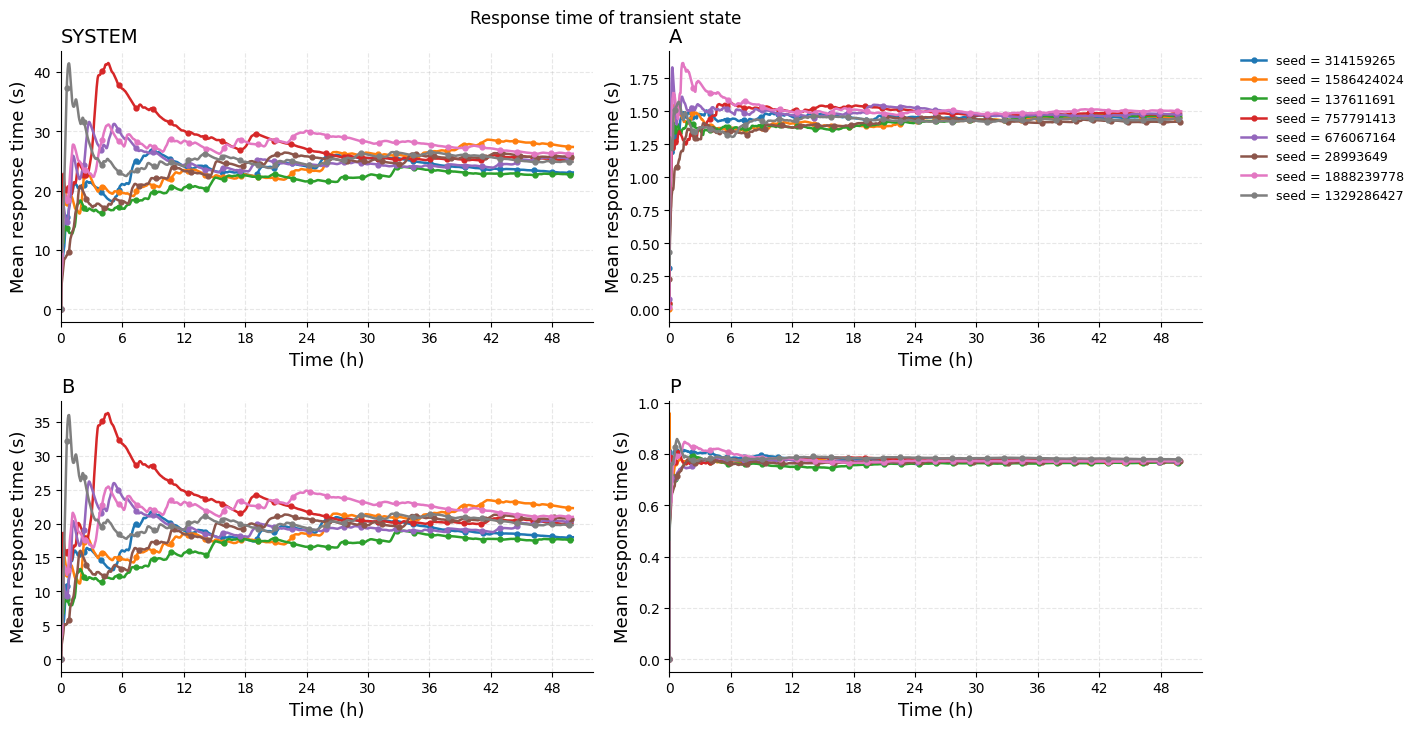

In [75]:
OBJ = 3
#config_file = f"obj4_p_var_loop.json"
#config_file = f"obj1.json"
config_file = f"obj1.json"
arrival_rate = 1.2

config_path = f"analytic_sweep_lambda.csv"
TITLE_PREFIX = f"OBJ{OBJ}"
conv_files=find_csv_for_config(config_file,target="conv")

# 2) li carico come LISTA di DF (uno per file/seed)
dfs_conv = load_conv_as_list(conv_files)
dfs=[]
for df in dfs_conv:
    dc=df.copy()
    dc["time"]=dc["time"].astype(float)/3600.0
    dfs.append(dc)


plot_transient_rt_paper_style(
    dfs_conv_list=dfs,
    arrival_rate=arrival_rate,
    scopes=("OVERALL", "NODE_A","NODE_B","NODE_P"),  # TL=SYSTEM, TR=A, BL=P, BR=B
    t_max=(50.0),
    downsample_every=1,
    ewma_span=7,
    analytic_df=None,
    log = False,
    fig_name="Obj1-transient-rt.png",
)